Binary class distribution: Counter({1: 4651, 0: 231})
Balanced training distribution: Counter({0: 3720, 1: 3720})

===== LOGISTIC REGRESSION K-FOLD =====


/var/folders/pz/p1hrncws1n5gsmzgxczt0rpm0000gn/T/ipykernel_3593/1909776961.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_train = df_train.groupby("Engagement", group_keys=False).apply(



---- Fold 1 ----
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       744
           1       0.70      0.70      0.70       744

    accuracy                           0.70      1488
   macro avg       0.70      0.70      0.70      1488
weighted avg       0.70      0.70      0.70      1488

[[521 223]
 [226 518]]

---- Fold 2 ----
              precision    recall  f1-score   support

           0       0.67      0.71      0.69       744
           1       0.69      0.65      0.67       744

    accuracy                           0.68      1488
   macro avg       0.68      0.68      0.68      1488
weighted avg       0.68      0.68      0.68      1488

[[529 215]
 [263 481]]

---- Fold 3 ----
              precision    recall  f1-score   support

           0       0.72      0.71      0.71       744
           1       0.71      0.72      0.72       744

    accuracy                           0.72      1488
   macro avg       0.72     

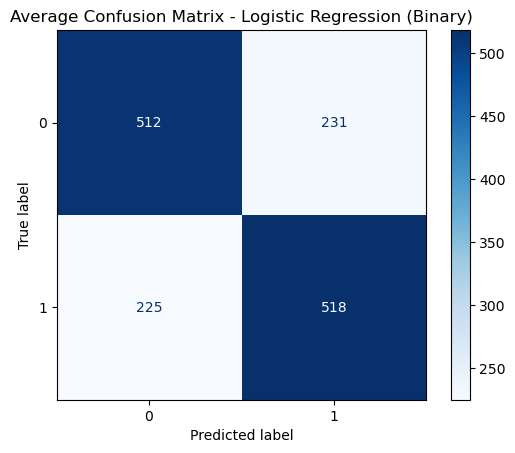


===== K-FOLD AVERAGE METRICS =====
Accuracy  : 0.693
Precision : 0.692
Recall    : 0.697
F1 Score  : 0.694

===== VALIDATION PERFORMANCE (Binary) =====
              precision    recall  f1-score   support

           0       0.10      0.61      0.17        23
           1       0.97      0.73      0.83       465

    accuracy                           0.72       488
   macro avg       0.54      0.67      0.50       488
weighted avg       0.93      0.72      0.80       488

[[ 14   9]
 [127 338]]


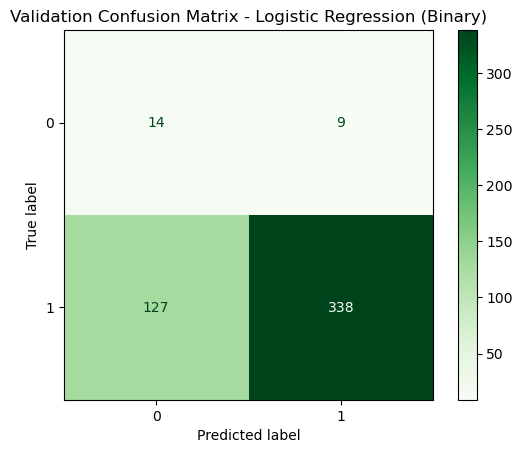

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, f1_score, accuracy_score,
    precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# --- Load dataset ---
data = pd.read_csv("/Users/khushnumaparveen/Downloads/merged_results.csv")

# --- Select features ---
au_cols = [col for col in data.columns if col.startswith("au")]
landmark_cols = [col for col in data.columns if col.startswith("x_") or col.startswith("y_")]
possible_pose_cols = ["pose_Rx", "pose_Ry", "pose_Rz", "pitch", "yaw", "roll"]
pose_cols = [col for col in possible_pose_cols if col in data.columns]

feature_cols = au_cols + landmark_cols + pose_cols
X = data[feature_cols].fillna(0)

# ------------------------------
# Convert Engagement 0–3 → Binary (0,1)
# ------------------------------
y = (data["Engagement"] >= 2).astype(int)
print("Binary class distribution:", Counter(y))

# ------------------------------
# Train / Validation / Test Split
# ------------------------------
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# ------------------------------
# Balance TRAIN-ONLY using oversampling
# ------------------------------
df_train = pd.concat([X_train_full, y_train_full], axis=1)
max_size = df_train["Engagement"].value_counts().max()

balanced_train = df_train.groupby("Engagement", group_keys=False).apply(
    lambda x: x.sample(max_size, replace=True, random_state=42)
).reset_index(drop=True)

X_bal = balanced_train[feature_cols]
y_bal = balanced_train["Engagement"]

print("Balanced training distribution:", Counter(y_bal))

# ------------------------------
# Scale Data
# ------------------------------
scaler = StandardScaler()
X_bal_scaled = scaler.fit_transform(X_bal)
X_val_scaled = scaler.transform(X_val)

# ------------------------------
# STRATIFIED K-FOLD (5 folds)
# ------------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accs, precs, recs, f1s = [], [], [], []
all_cm = np.zeros((2, 2), dtype=int)

print("\n===== LOGISTIC REGRESSION K-FOLD =====")

for fold, (train_idx, test_idx) in enumerate(skf.split(X_bal_scaled, y_bal), 1):
    X_train, X_test_fold = X_bal_scaled[train_idx], X_bal_scaled[test_idx]
    y_train, y_test_fold = y_bal.iloc[train_idx], y_bal.iloc[test_idx]

    # model = LogisticRegression(
    #     solver='liblinear',   # good for small/medium datasets
    #     class_weight='balanced',
    #     max_iter=1000,
    #     random_state=42
    # 
    model = LogisticRegression(
        C=5.0,
        penalty="l2",
        solver="lbfgs",
        class_weight="balanced",
        max_iter=2000,
        random_state=42
    )

    model.fit(X_train, y_train)
    pred = model.predict(X_test_fold)

    accs.append(accuracy_score(y_test_fold, pred))
    precs.append(precision_score(y_test_fold, pred, zero_division=0))
    recs.append(recall_score(y_test_fold, pred, zero_division=0))
    f1s.append(f1_score(y_test_fold, pred, zero_division=0))

    cm = confusion_matrix(y_test_fold, pred, labels=[0, 1])
    all_cm += cm

    print(f"\n---- Fold {fold} ----")
    print(classification_report(y_test_fold, pred))
    print(cm)

# ------------------------------
# Average Confusion Matrix
# ------------------------------
avg_cm = all_cm // 5
print("\n===== AVERAGE CONFUSION MATRIX =====")
print(avg_cm)

disp = ConfusionMatrixDisplay(confusion_matrix=avg_cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')
plt.title("Average Confusion Matrix - Logistic Regression (Binary)")
plt.show()

print("\n===== K-FOLD AVERAGE METRICS =====")
print(f"Accuracy  : {np.mean(accs):.3f}")
print(f"Precision : {np.mean(precs):.3f}")
print(f"Recall    : {np.mean(recs):.3f}")
print(f"F1 Score  : {np.mean(f1s):.3f}")

# ------------------------------
# Train FINAL Logistic Regression Model
# ------------------------------
final_model = LogisticRegression(
        C=5.0,
        penalty="l2",
        solver="lbfgs",
        class_weight="balanced",
        max_iter=2000,
        random_state=42
)

final_model.fit(X_bal_scaled, y_bal)

# ------------------------------
# Validation Performance
# ------------------------------
val_pred = final_model.predict(X_val_scaled)

print("\n===== VALIDATION PERFORMANCE (Binary) =====")
print(classification_report(y_val, val_pred))

val_cm = confusion_matrix(y_val, val_pred)
print(val_cm)

disp = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=[0, 1])
disp.plot(cmap="Greens", values_format='d')
plt.title("Validation Confusion Matrix - Logistic Regression (Binary)")
plt.show()



===== LOGISTIC REGRESSION — TEST SET =====
              precision    recall  f1-score   support

           0       0.10      0.78      0.18        23
           1       0.98      0.67      0.80       466

    accuracy                           0.67       489
   macro avg       0.54      0.72      0.49       489
weighted avg       0.94      0.67      0.77       489

[[ 18   5]
 [155 311]]


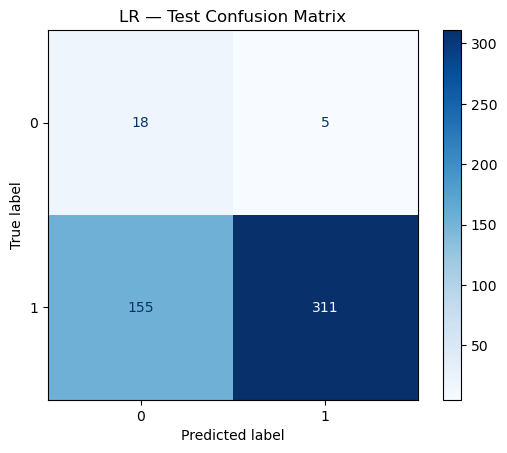

In [11]:
X_test_scaled = scaler.transform(X_test)   # scale test set
test_pred = final_model.predict(X_test_scaled)

print("\n===== LOGISTIC REGRESSION — TEST SET =====")
print(classification_report(y_test, test_pred))

test_cm = confusion_matrix(y_test, test_pred)
print(test_cm)

disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=[0,1])
disp.plot(cmap="Blues", values_format='d')
plt.title("LR — Test Confusion Matrix")
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix

def accuracy_details(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()

    acc_class_0 = tn / (tn + fn + 1e-9)
    acc_class_1 = tp / (tp + fp + 1e-9)
    overall_acc = (tp + tn) / (tp + tn + fp + fn)

    print("Confusion Matrix:\n", cm)
    print(f"\nAccuracy Class 0 (Disengaged): {acc_class_0:.3f}")
    print(f"Accuracy Class 1 (Engaged)   : {acc_class_1:.3f}")
    print(f"Overall Accuracy             : {overall_acc:.3f}")

accuracy_details(y_test,test_pred)

Confusion Matrix:
 [[ 18   5]
 [155 311]]

Accuracy Class 0 (Disengaged): 0.104
Accuracy Class 1 (Engaged)   : 0.984
Overall Accuracy             : 0.673
